# KNN Model for predicting Age with Peaks - Vibration

Energy

Import

In [1]:
import os
import glob
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from scipy.io import wavfile
from scipy.fft import fft
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from scipy.signal import find_peaks
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score
# import openpyxl


Readwav function

In [2]:
def readAllFileVibration(folderPath):
    csv_data = []
    for root, dirs, files in os.walk(folderPath):
        for file in files:
            if file.endswith(".csv"):
                file_path = os.path.join(root, file)
                folder_name = os.path.basename(root)
                df = pd.read_csv(file_path)
                csv_data.append((folder_name, df))
    return csv_data
    
P1=readAllFileVibration("../../Data_Clean/Chanel0_Data_Columns/P1_clean")



# print(allDataTest)

Spectrum

In [3]:
def spectrumFromSignal(signal, sample_rate):
    spectrum = fft(signal[:, 0])  # Compute the FFT for the first column
    freqs = np.fft.fftfreq(len(spectrum), d=1/sample_rate)[:len(spectrum) // 2]  # Compute frequency bins
    spectrum = abs(spectrum[:len(spectrum) // 2])  # Compute magnitude of the spectrum

    # Filter the spectrum and frequencies between 150 Hz and 1000 Hz
    mask = (freqs >= 150) & (freqs <= 1000)
    return spectrum[mask], freqs[mask]

testData = P1[0][1].to_numpy()
# print(testData)
testDataSpectrum, freqTest = spectrumFromSignal(testData, 20000)

Plot Spectrum

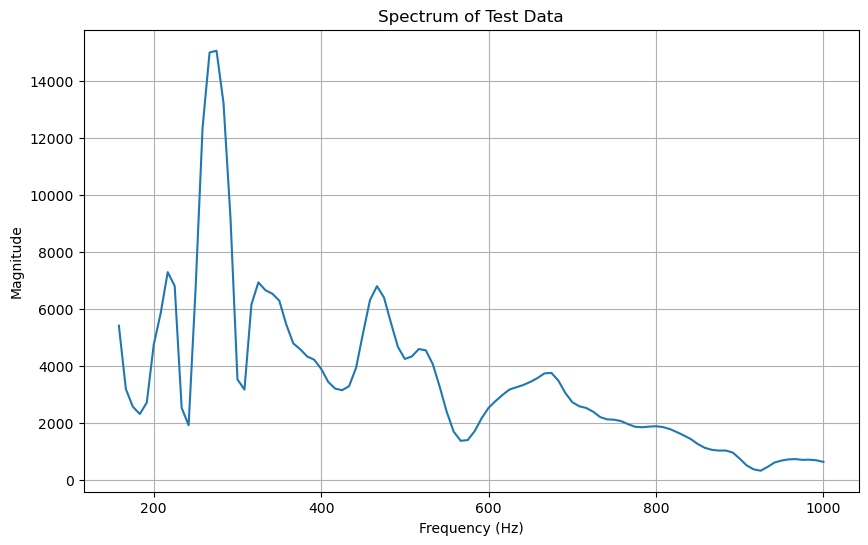

In [4]:
def plot_spectrum_with_freq(signal, freqs, title="Spectrum Plot"):
    magnitude = abs(signal)  # Compute magnitude of the spectrum

    plt.figure(figsize=(10, 6))
    plt.plot(freqs, magnitude)
    plt.title(title)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.grid()
    plt.show()  

# Example usage
plot_spectrum_with_freq(testDataSpectrum, freqTest, title="Spectrum of Test Data")


Extract each peak and store

[99 97 87 77 62 43 37 20  7 14] {'peak_heights': array([  705.20407143,   725.98183826,  1027.30486884,  1881.73211415,
        3756.06315583,  4592.80749623,  6800.78825497,  6935.68001228,
        7294.61213095, 15073.55648925])}


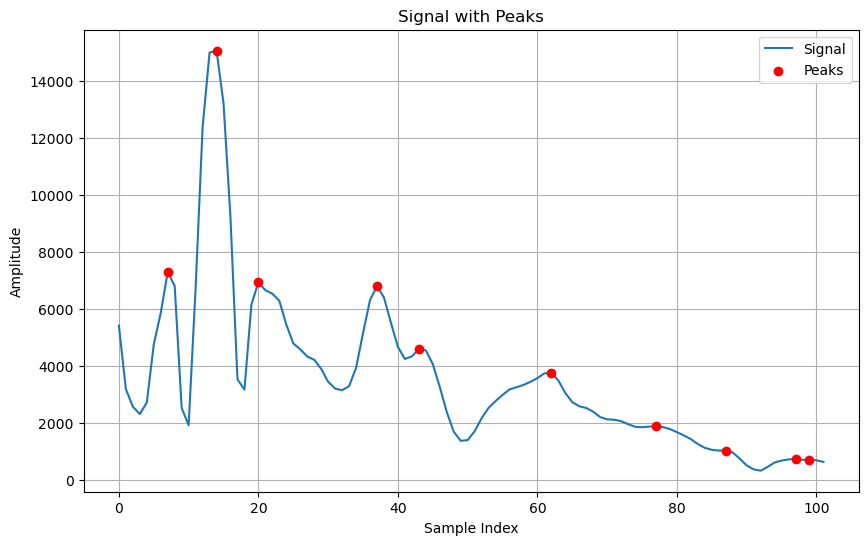

In [5]:
def extractPeakFromSignal(signal, smoothing=1, num_peaks=None):
    # Ensure the signal is a 1-D array
    signalFile = signal.flatten()
    
    # Smooth the signal using a moving average filter
    window_size = smoothing  # Define the window size for smoothing
    smoothed_signal = np.convolve(signalFile, np.ones(window_size)/window_size, mode='same')
    signalFile = smoothed_signal

    # Find peaks in the signal
    peaks, properties = find_peaks(signalFile, height=10)
    
    # If num_peaks is specified, select the top N peaks based on height
    if num_peaks is not None:
        sorted_indices = np.argsort(properties["peak_heights"])[-num_peaks:]
        peaks = peaks[sorted_indices]
        properties["peak_heights"] = properties["peak_heights"][sorted_indices]
    
    return peaks, properties


peaks,peaksAmplitude=extractPeakFromSignal(testDataSpectrum,num_peaks=10)
print(peaks,peaksAmplitude)

# Plot the signal with the peaks
plt.figure(figsize=(10, 6))
plt.plot(testDataSpectrum, label="Signal")
plt.scatter(peaks, testDataSpectrum[peaks], color="red", label="Peaks", zorder=5)
plt.title("Signal with Peaks")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()

Energy

In [6]:
def energy_per_frequency_band_from_spectrum(spectrum, freqs, band_width):
    # Calculate energy per band
    band_energies = []
    band_frequencies = []
    for start_freq in range(0, int(freqs[-1]), band_width):
        end_freq = start_freq + band_width
        band_indices = np.where((freqs >= start_freq) & (freqs < end_freq))[0]
        band_energy = np.sum(spectrum[band_indices]**2)  # Sum of squared magnitudes
        band_energies.append(band_energy)
        band_frequencies.append((start_freq + end_freq) / 2)  # Center frequency of the band

    return band_energies, band_frequencies

energy_per_frequency_band_from_spectrum(testDataSpectrum,freqTest,50)

([0.0,
  0.0,
  0.0,
  81335086.20107675,
  189294058.93866268,
  877930251.6240737,
  222685992.1414923,
  125454846.18268713,
  84791962.27737181,
  197384931.03200537,
  93400547.23551741,
  20644891.068747334,
  60104199.862182364,
  69717174.71427926,
  32554877.79067917,
  21962522.744057637,
  15428711.378486134,
  5940914.97073922,
  1518548.3100271935,
  2889876.0221517924],
 [25.0,
  75.0,
  125.0,
  175.0,
  225.0,
  275.0,
  325.0,
  375.0,
  425.0,
  475.0,
  525.0,
  575.0,
  625.0,
  675.0,
  725.0,
  775.0,
  825.0,
  875.0,
  925.0,
  975.0])

# Main

In [7]:
raquetteTypeList = {"RB":0,"RO":1,"RR":2,"RV":3}
raquetteAgeList = {"P1":1,"P2":2,"P3":3}



sampleRateFolderP1=[]
sampleRateFolderP2=[]
sampleRateFolderP3=[]

P1=readAllFileVibration("../../Data_Clean/Chanel0_Data_Columns/P1_clean")
P2=readAllFileVibration("../../Data_Clean/Chanel0_Data_Columns/P2_clean")
P3=readAllFileVibration("../../Data_Clean/Chanel0_Data_Columns/P3_clean")

print(len(P1),len(P2),len(P3))


# Combine all data into a single DataFrame with equal repartition of ages
all_data = []

# Find the minimum number of samples across all ages
min_samples_per_age = min(len(P1), len(P2), len(P3))

# Limit the data for each age to the minimum number of samples
for dataset, age in zip([P1[:min_samples_per_age], P2[:min_samples_per_age], P3[:min_samples_per_age]], ["P1", "P2", "P3"]):
    for label, df in dataset:
        spectrum_points = df.iloc[:, 0].tolist()  # Convert the first column to a list of spectrum points
        all_data.append({
            "Spectrum": spectrum_points,
            "Label": label,
            "Age": age
        })

# Convert the list of dictionaries into a DataFrame
df_combined = pd.DataFrame(all_data)
print(df_combined)




216 324 255
                                              Spectrum Label Age
0    [-0.0157396069269226, -0.0247020394436264, -0....    RB  P1
1    [0.1018583712467967, 0.1009078102222978, 0.088...    RB  P1
2    [-0.027010544788838, -0.0150606347665663, -0.0...    RB  P1
3    [-0.0568732668509613, -0.0635271940224535, -0....    RB  P1
4    [-0.0867480419066406, -0.0499477508153265, -0....    RB  P1
..                                                 ...   ...  ..
643  [-0.0032282485048386, -0.0111029046295602, -0....    RV  P3
644  [-0.0174840914892484, -0.0420584493957072, -0....    RV  P3
645  [-0.0583508413778898, -0.0398861304647495, -0....    RV  P3
646  [-0.0147686928255513, -0.0130036836941482, 0.0...    RV  P3
647  [-0.008523275899048, -0.0104240549636359, 0.01...    RV  P3

[648 rows x 3 columns]


In [8]:
peaksHzList=[]
peaksAmplitudeList=[]
for spectrum in df_combined["Spectrum"]:
    peaksHz, peaksAmplitude = extractPeakFromSignal(np.array(spectrum),num_peaks=7)
    peaksHzList.append(peaksHz)
    peaksAmplitudeList.append(peaksAmplitude["peak_heights"])
    print(peaksAmplitude["peak_heights"])
    

[ 76.98119712  79.54377384 106.59823434 218.23130629 219.9480195
 224.48287456 225.83348598]
[ 75.65204122  77.57747047  80.50275412 171.25322252 216.27287899
 222.81667688 225.17610514]
[ 89.12610794  91.28021502 157.9934394  171.16373398 225.57384703
 232.29988104 235.69080381]
[ 49.2870211   49.64483943  49.67512159  64.78958506  78.34431368
 183.22894553 184.38795101]
[ 49.06241711  62.15164242  71.28734863 105.56512235 166.45425934
 171.07235638 172.16197091]
[ 47.90694229  48.68613074  52.13055651  54.63039621  74.39962122
 172.47823614 176.45198861]
[ 55.60378258  60.63659582  66.31551897 189.98432302 192.03223885
 198.3745178  199.14352167]
[ 58.91621616  81.88394322  83.5941383   84.67832104 204.403519
 217.86129039 217.94955677]
[ 88.65777688  94.07692528  96.40321969 191.55614357 203.86495828
 224.27499721 233.86072617]
[ 99.39256099  99.99901892 100.60330415 202.14236858 237.79750522
 251.54302502 256.13165467]
[ 67.14993842  69.27349175  85.09367888  86.01613046 141.590409

In [9]:
min_len_peaksAmplitudeList = min(len(arr) for arr in peaksAmplitudeList)
print(min_len_peaksAmplitudeList)

7


In [10]:
# Combine peaksHzList and peaksAmplitudeList into a matrix
X = peaksAmplitudeList
X = np.hstack([np.array(peaksHzList), np.array(peaksAmplitudeList)])

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_combined["Age"])

# # print(y)
# print(len(X),len(y))

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# print(X,y)

In [11]:
# Définir les bonnes valeurs trouvé
n_neighbors = 10  # Nombre de voisins
weights_options = ['uniform']  # Méthode de pondération
metric_options = ['manhattan']  # Métriques


# Définir les plages de valeurs pour les hyperparamètres
n_neighbors_range = range(1, 21)  # Nombre de voisins
weights_options = ['uniform', 'distance']  # Méthode de pondération
metric_options = ['euclidean', 'manhattan', 'chebyshev', 'minkowski']  # Métriques

# Liste pour stocker les résultats
results = []


# Tester toutes les combinaisons d'hyperparamètres
for n_neighbors in n_neighbors_range:
    for weights in weights_options:
        for metric in metric_options:
            # Créer et entraîner le modèle KNN
            knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric=metric)
            knn.fit(X_train, y_train)

            # Évaluer sur l'ensemble de test
            y_pred = knn.predict(X_test)
            accuracy_test = accuracy_score(y_test, y_pred)

            # Évaluer sur l'ensemble d'entraînement
            y_train_pred = knn.predict(X_train)
            accuracy_train = accuracy_score(y_train, y_train_pred)

            # Ajouter les résultats à la liste
            results.append({
                'n_neighbors': n_neighbors,
                'weights': weights,
                'metric': metric,
                'accuracy_train': accuracy_train,
                'accuracy_test': accuracy_test
            })

# Convertir les résultats en DataFrame
results_df = pd.DataFrame(results)



print(results_df)
print(results_df["accuracy_test"].max())

     n_neighbors   weights     metric  accuracy_train  accuracy_test
0              1   uniform  euclidean        1.000000       0.707692
1              1   uniform  manhattan        1.000000       0.800000
2              1   uniform  chebyshev        1.000000       0.592308
3              1   uniform  minkowski        1.000000       0.707692
4              1  distance  euclidean        1.000000       0.707692
..           ...       ...        ...             ...            ...
155           20   uniform  minkowski        0.683398       0.592308
156           20  distance  euclidean        1.000000       0.669231
157           20  distance  manhattan        1.000000       0.784615
158           20  distance  chebyshev        1.000000       0.523077
159           20  distance  minkowski        1.000000       0.669231

[160 rows x 5 columns]
0.8


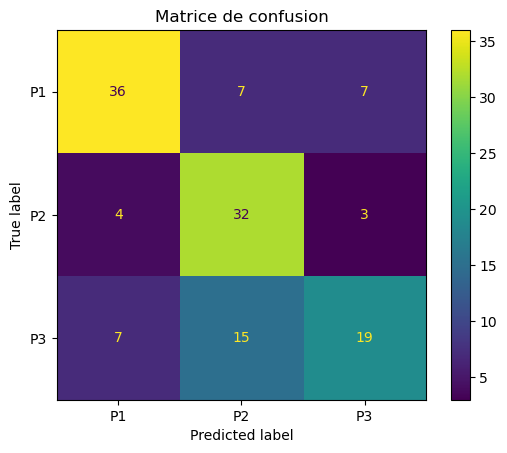

In [12]:
from sklearn.metrics import ConfusionMatrixDisplay

# Afficher la matrice de confusion
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=label_encoder.classes_)
plt.title("Matrice de confusion")
plt.show()
